# Lux AI Season 2 Tutorial - Python Kit

Welcome to Lux AI Season 2!

This notebook is the basic setup to use Jupyter Notebooks and the kaggle-environments package to develop your bot. If you plan to not use Jupyter Notebooks or any other programming language, please see our Github. The following are some important links!

Competition Page: https://www.kaggle.com/c/lux-ai-season-2/

Online Visualizer: https://s2vis.lux-ai.org/

Specifications: https://www.lux-ai.org/specs-s2

Github: https://github.com/Lux-AI-Challenge/Lux-Design-S2

Bot API: https://github.com/Lux-AI-Challenge/Lux-Design-S2/tree/main/kits

And if you haven't done so already, we highly recommend you join our Discord server at https://discord.gg/aWJt3UAcgn or at the minimum follow the kaggle forums at https://www.kaggle.com/c/lux-ai-season-2/discussion. We post important announcements there such as changes to rules, events, and opportunities from our sponsors!

Now let's get started!

## Prerequisites
We assume that you have a basic knowledge of Python and programming. It's okay if you don't know the game specifications yet! Feel free to always refer back to https://www.lux-ai.org/specs-s2.

## Basic Setup
First thing to verify is that you have python 3.7 or above and have the [luxai_s2](https://pypi.org/project/luxai_s2/) package installed

In [1]:
# verify version
#!python --version
#!pip install --upgrade luxai_s2
#!pip install importlib-metadata==4.13.0
#!pip install --upgrade moviepy # needed to render videos of episodes

Python 3.10.9
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.3/388.3 kB 3.6 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 26.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.5/22.5 MB 40.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 5.7 MB/s eta 0:00:00
  Created wheel for moviepy: filename=moviepy-1.0.3-py3-none-any.whl size=110727 sha256=02c3681060b86a8f49fc3cdfd17c320752f45132cc6468c43d7420d073892160
  Stored in directory: /Users/oceguerac/Library/Caches/pip/wheels/96/32/2d/e10123bd88fbfc02fed53cc18c80a171d3c87479ed84

In [1]:
from luxai_s2.env import LuxAI_S2
import matplotlib.pyplot as plt
import numpy as np

We can now create an environment and start interacting with it, as well as look at what the observation is like

In [10]:
env = LuxAI_S2() # create the environment object
obs = env.reset(seed=41) # resets an environment with a seed

In [3]:
#return the "Manhattan distance"
from scipy.ndimage import distance_transform_cdt

def manhattan_distance(binary_mask):
    # Get the distance map from every pixel to the nearest positive pixel
    distance_map = distance_transform_cdt(binary_mask, metric='taxicab')

    return distance_map

best starting location by distance to the nearest ice/ore is (3, 30)


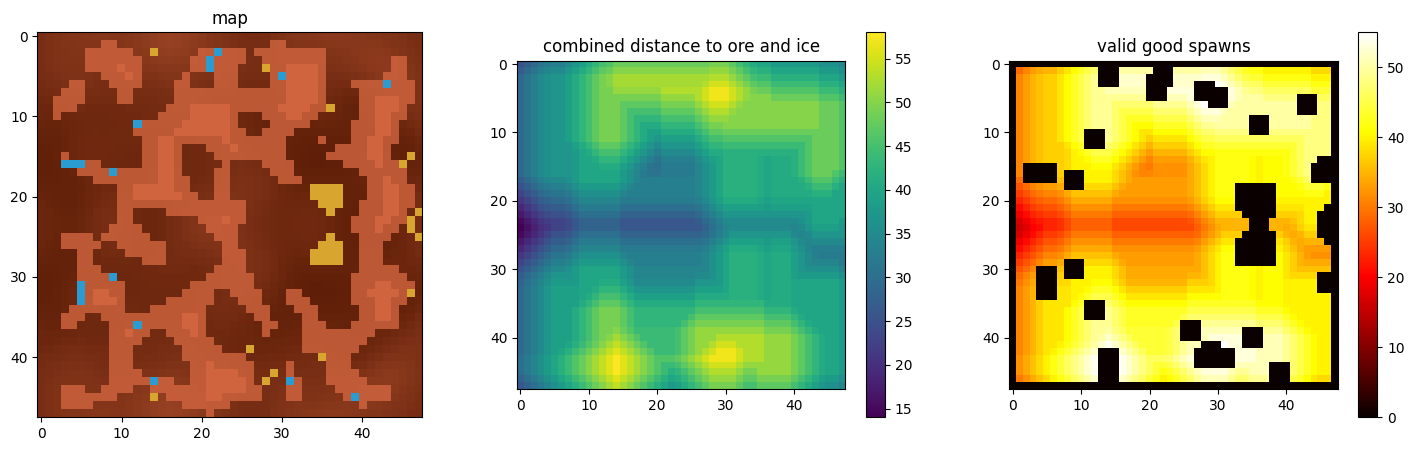

In [9]:
#search where is the ice and where is the ore in the map
ice = obs["player_0"]["board"]["ice"]
ore = obs["player_0"]["board"]["ore"]
rubble = obs["player_0"]["board"]["rubble"]

#calculate the distance between
dist_ice = manhattan_distance(1 - ice)
dist_ice = np.max(dist_ice) - dist_ice
dist_ore = manhattan_distance(1 - ore)
dist_ore = np.max(dist_ore) - dist_ore

#we give a score to each point using the distance of ore and ice
score = dist_ice + dist_ore
#obs["player_0"]["board"]["valid_spawns_mask"] give us a TRUE FALSE matrix, the next code give us the distance of the valid spots
valid_good_spawns = score * obs["player_0"]["board"]["valid_spawns_mask"]

#Now we define the best location to spawn
best_loc = np.argmax(valid_good_spawns)
x, y = np.unravel_index(best_loc, (48, 48)) # 48,48 is because is the size of the map
print(f"best starting location by distance to the nearest ice/ore is {(x, y)}")

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

mapa = env.render("rgb_array", width=48, height=48).transpose(1,0,2) # not sure why he use this tipe of transpose
# explanation I found on Github OpenCV img = cv2.imread(path) loads an image with HWC-layout (height, width, channels), while Pytorch requires CHW-layout. So we have to do np.transpose(image,(2,0,1)) for HWC->CHW transformation.
im1 = ax1.imshow(mapa)
ax1.set_title('map')

im2 = ax2.imshow(score)
ax2.set_title('combined distance to ore and ice')
fig.colorbar(im2, ax=ax2)

im3 = ax3.imshow(valid_good_spawns, cmap='hot')
ax3.set_title('valid good spawns')
fig.colorbar(im3, ax=ax3)

plt.show()

In [5]:
# Lets do the same but to find places with more than 1 ice or ore

from scipy.spatial import KDTree

def manhattan_dist_to_nth_closest(arr, n):
    if n == 1:
        distance_map = distance_transform_cdt(1-arr, metric='taxicab')
        return distance_map
    else:
        true_coords = np.transpose(np.nonzero(arr)) # get the coordinates of true values
        tree = KDTree(true_coords) # build a KDTree
        dist, _ = tree.query(np.transpose(np.nonzero(~arr)), k=n, p=1) # query the nearest to nth closest distances using p=1 for Manhattan distance
        return np.reshape(dist[:, n-1], arr.shape) # reshape the result to match the input shape and add an extra dimension for the different closest distances

Text(0.5, 1.0, 'distance to 7th closest ice')

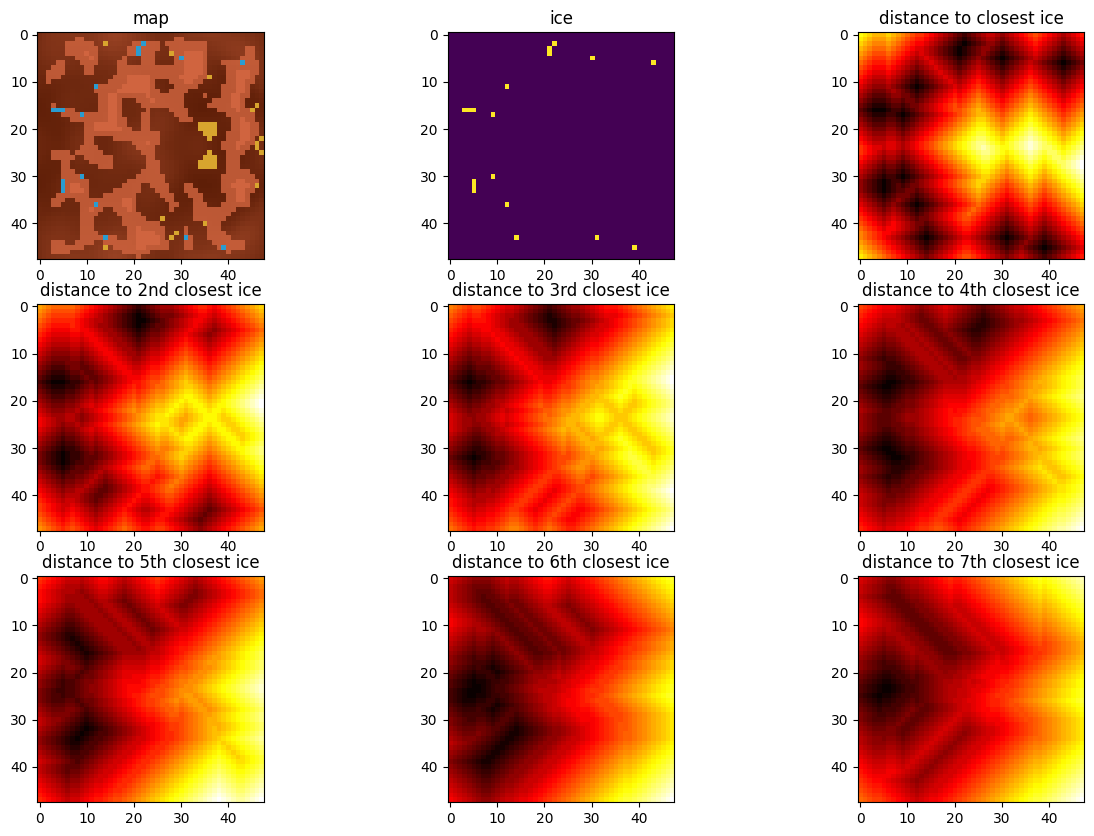

In [56]:
# this is the distance to the n-th closest ice, for each coordinate
ice_distances = [manhattan_dist_to_nth_closest(ice, i) for i in range(1,8)] #the (1,8) look for positions nearest to i ices
#in an ideal work we should search for the "best position" so increase the number until the conditions start to get bad

# this is the distance to the n-th closest ore, for each coordinate
ore_distances = [manhattan_dist_to_nth_closest(ore, i) for i in range(1,8)]

len(ice_distances)
#print(ice_distances)
fig, axs = plt.subplots(3, 3, figsize=(15, 10))
axs[0, 0].imshow(mapa)
axs[0, 0].set_title('map')
axs[0, 1].imshow(ice)
axs[0, 1].set_title('ice')
axs[0, 2].imshow(ice_distances[0], cmap='hot')
axs[0, 2].set_title('distance to closest ice')
axs[1, 0].imshow(ice_distances[1], cmap='hot')
axs[1, 0].set_title('distance to 2nd closest ice')
axs[1, 1].imshow(ice_distances[2], cmap='hot')
axs[1, 1].set_title('distance to 3rd closest ice')
axs[1, 2].imshow(ice_distances[3], cmap='hot')
axs[1, 2].set_title('distance to 4th closest ice')
axs[2, 0].imshow(ice_distances[4], cmap='hot')
axs[2, 0].set_title('distance to 5th closest ice')
axs[2, 1].imshow(ice_distances[5], cmap='hot')
axs[2, 1].set_title('distance to 6th closest ice')
axs[2, 2].imshow(ice_distances[6], cmap='hot')
axs[2, 2].set_title('distance to 7th closest ice')


In [57]:
a=1/len(ice_distances)
b=0
secuencia = []
for i in range(len(ice_distances)):
 b=b+a
 secuencia.append(b)

Weights = secuencia[::-1]
print(Weights)

ICE_WEIGHTS = np.array(Weights) # tenemos que usar len(ice_distances) para asignar el peso, podriamos simplemente repetir 0.25 n veces para aumentar el peso de esos sitios


[0.9999999999999998, 0.857142857142857, 0.7142857142857142, 0.5714285714285714, 0.42857142857142855, 0.2857142857142857, 0.14285714285714285]


best starting location according to weighted distances to ore and ice is (4, 23)


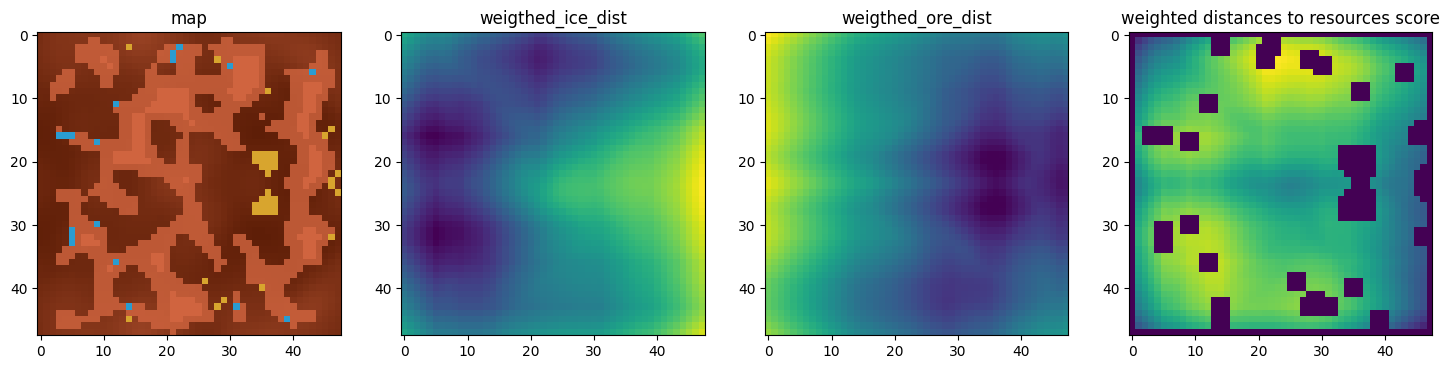

In [59]:
ICE_WEIGHTS = np.array(Weights) # tenemos que usar len(ice_distances) para asignar el peso, podriamos simplemente repetir 0.25 n veces para aumentar el peso de esos sitios
weigthed_ice_dist = np.sum(np.array(ice_distances) * ICE_WEIGHTS[:, np.newaxis, np.newaxis], axis=0)


ORE_WEIGHTS = np.array(Weights)
weigthed_ore_dist = np.sum(np.array(ore_distances) * ORE_WEIGHTS[:, np.newaxis, np.newaxis], axis=0)

ICE_PREFERENCE = 2 # if you want to make ore more important, change to 0.3 for example

combined_resource_score = (weigthed_ice_dist * ICE_PREFERENCE + weigthed_ore_dist)
combined_resource_score = (np.max(combined_resource_score) - combined_resource_score) * obs["player_0"]["board"]["valid_spawns_mask"]


best_loc = np.argmax(combined_resource_score)
x, y = np.unravel_index(best_loc, (48, 48))
print(f"best starting location according to weighted distances to ore and ice is {(x, y)}")

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(18, 5))

im1 = ax1.imshow(mapa)
ax1.set_title('map')

im2 = ax2.imshow(weigthed_ice_dist)
ax2.set_title('weigthed_ice_dist')

im3 = ax3.imshow(weigthed_ore_dist)
ax3.set_title('weigthed_ore_dist')

im4 = ax4.imshow(combined_resource_score)
ax4.set_title('weighted distances to resources score')

plt.show()         

Time to include low rubble areas in the calculation.
In order to grow lichen, we need to clean cells, directly connected to our factory, from all rubble. So, the best strategy is to find low rubble zones, and place our factory right next to them.

Below, we calculate how many low-rubble cells there are near each possible factory location.

We have 2 important parameters here:

maximum_depth, which controls how far away we search for low-rubble areas
exponent, which controls how much we care for more distant areas
Here is a visualization of what locations are good for this map, focusing only on the rubble. Again, feel free to tweak the parameters and test.

<Figure size 960x720 with 0 Axes>

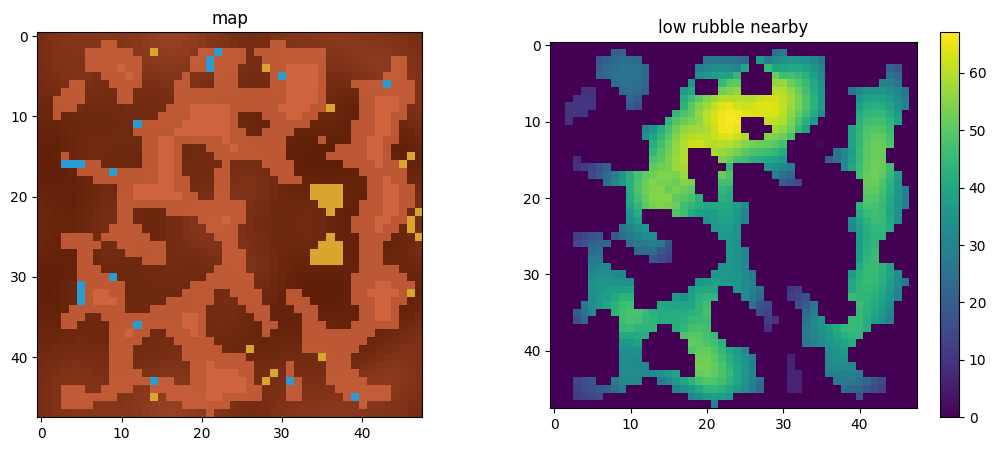

In [61]:
low_rubble = (rubble<25)

def count_region_cells(array, start, min_dist=2, max_dist=np.inf, exponent=1):
    
    def dfs(array, loc):
        distance_from_start = abs(loc[0]-start[0]) + abs(loc[1]-start[1])
        if not (0<=loc[0]<array.shape[0] and 0<=loc[1]<array.shape[1]):   # check to see if we're still inside the map
            return 0
        if (not array[loc]) or visited[loc]:     # we're only interested in low rubble, not visited yet cells
            return 0
        if not (min_dist <= distance_from_start <= max_dist):      
            return 0
        
        visited[loc] = True

        count = 1.0 * exponent**distance_from_start
        count += dfs(array, (loc[0]-1, loc[1]))
        count += dfs(array, (loc[0]+1, loc[1]))
        count += dfs(array, (loc[0], loc[1]-1))
        count += dfs(array, (loc[0], loc[1]+1))

        return count

    visited = np.zeros_like(array, dtype=bool)
    return dfs(array, start)

low_rubble_scores = np.zeros_like(low_rubble, dtype=float)

for i in range(low_rubble.shape[0]):
    for j in range(low_rubble.shape[1]):
        low_rubble_scores[i,j] = count_region_cells(low_rubble, (i,j), min_dist=0, max_dist=8, exponent=0.9)



plt.figure(dpi=150)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

im1 = ax1.imshow(mapa)
ax1.set_title('map')

im2 = ax2.imshow(low_rubble_scores)
ax2.set_title('low rubble nearby')
fig.colorbar(im2, ax=ax2)

best starting location according to the combined resource and rubble metrics is (8, 23)


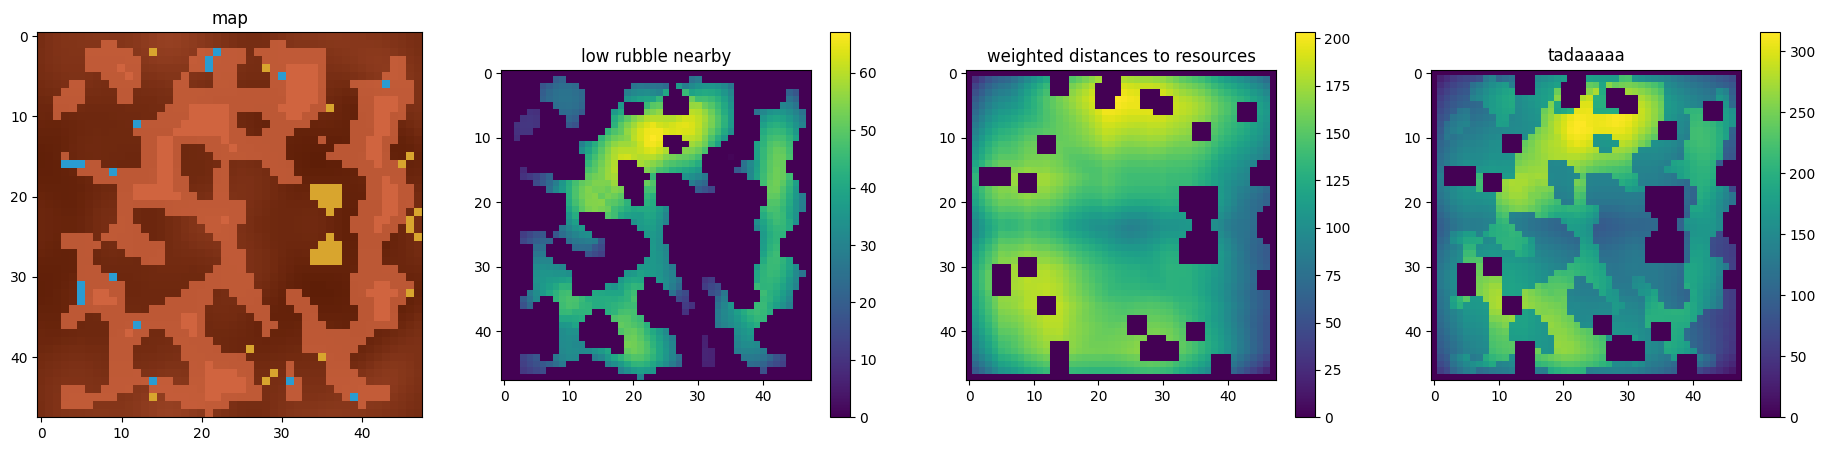

In [64]:
#Overal best place 
overall_score = (low_rubble_scores*2 + combined_resource_score ) * obs["player_0"]["board"]["valid_spawns_mask"]

best_loc = np.argmax(overall_score)
x, y = np.unravel_index(best_loc, (48, 48))
print(f"best starting location according to the combined resource and rubble metrics is {(x, y)}")

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(23, 5))

im1 = ax1.imshow(mapa)
ax1.set_title('map')

im2 = ax2.imshow(low_rubble_scores)
ax2.set_title('low rubble nearby')
fig.colorbar(im2, ax=ax2)

im3 = ax3.imshow(combined_resource_score)
ax3.set_title('weighted distances to resources')
fig.colorbar(im3, ax=ax3)

im4 = ax4.imshow(overall_score)
ax4.set_title('tadaaaaa')
fig.colorbar(im4, ax=ax4)

In [5]:
# the observation is always composed of observations for both players.
obs.keys(), obs["player_0"].keys()

(dict_keys(['player_0', 'player_1']),
 dict_keys(['units', 'teams', 'factories', 'board', 'real_env_steps', 'global_id']))

To visualize the environment, on jupyter notebooks you have two options

With the `rgb_array` mode you can visualize every step as an environment episode progresses. 

With the CLI tool, you can run an episode and save a replay.json to upload to https://s2vis.lux-ai.org/ or a replay.html file to directly open and watch

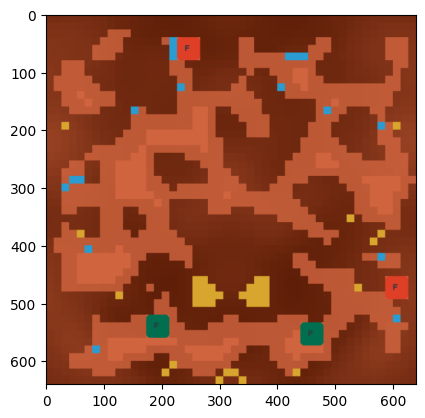

In [90]:
# visualize the environment so far with rgb_array to get a quick look at the map
# dark orange - high rubble, light orange - low rubble
# blue = ice, yellow = ore
img = env.render("rgb_array", width=640, height=640)
plt.imshow(img)

## Building an Agent
Now we know what the environment looks like, let's try building a working agent. The goal of this environment to ensure at least one factory stays alive by the end of the episode and grow as much lichen as possible.

In our kit we provide a skeleton for building an agent. Avoid removing any function from the kit unless you know what you are doing as it may cause your agent to fail on the competition servers. This agent defintion should be stored in the `agent.py` file.

The agent will have `self.player, self.opp_player, self.env_cfg` populated with the correct values at each step of an environment during competition or when you use the CLI tool to run matches. 

`self.env_cfg` stores the curent environment's configurations, and `self.player, self.opp_player` stores the name of your player/team and the opposition respectively (will always be "player_0" or "player_1").

In [66]:
from lux.kit import obs_to_game_state, GameState, EnvConfig
from luxai_s2.utils import animate
from lux.utils import direction_to, my_turn_to_place_factory
class Agent():
    def __init__(self, player: str, env_cfg: EnvConfig) -> None:
        self.player = player
        self.opp_player = "player_1" if self.player == "player_0" else "player_0"
        np.random.seed(0)
        self.env_cfg: EnvConfig = env_cfg

    def early_setup(self, step: int, obs, remainingOverageTime: int = 60):
        actions = dict()
        # optionally convert observations to python objects with utility functions
        game_state = obs_to_game_state(step, self.env_cfg, obs) 
        return actions

    def act(self, step: int, obs, remainingOverageTime: int = 60):
        actions = dict()
        game_state = obs_to_game_state(step, self.env_cfg, obs)
        return actions

Note that in season 2, there are two distinct phases of the game where you will have to program two different sets of logic to play it.

We will also define a simple function to initialize our agent and interact with the environment and generate a simple video replay.
No need to worry about how this works specifically, you can copy paste this as you see fit. Note that this is a simplified representation. In order to visually see all numbers and details about units, factories etc. use our web visualizer.

In [86]:
def animate(imgs, _return=True):
    # using cv2 to generate videos as moviepy doesn't work on kaggle notebooks
    import cv2
    import os
    import string
    import random
    video_name = ''.join(random.choice(string.ascii_letters) for i in range(18))+'.webm'
    height, width, layers = imgs[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'VP90')
    video = cv2.VideoWriter(video_name, fourcc, 10, (width,height))

    for img in imgs:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        video.write(img)
    video.release()
    if _return:
        from IPython.display import Video
        return Video(video_name)
def interact(env, agents, steps):
    # reset our env
    obs = env.reset(seed=41)
    np.random.seed(0)
    imgs = []
    step = 0
    # Note that as the environment has two phases, we also keep track a value called 
    # `real_env_steps` in the environment state. The first phase ends once `real_env_steps` is 0 and used below

    # iterate until phase 1 ends
    while env.state.real_env_steps < 0:
        if step >= steps: break
        actions = {}
        for player in env.agents:
            o = obs[player]
            a = agents[player].early_setup(step, o)
            actions[player] = a
        step += 1
        obs, rewards, dones, infos = env.step(actions)
        imgs += [env.render("rgb_array", width=48, height=48)]
    done = False
    while not done:
        if step >= steps: break
        actions = {}
        for player in env.agents:
            o = obs[player]
            a = agents[player].act(step, o)
            actions[player] = a
        step += 1
        obs, rewards, dones, infos = env.step(actions)
        imgs += [env.render("rgb_array", width=640, height=640)]
        done = dones["player_0"] and dones["player_1"]
    return animate(imgs)

### Early Phase

During the first turn of the game, each player is given the map, starting resources (N factories and N\*150 water and ore), and are asked to bid for who goes first/second. Each 1 bid removes 1 water and 1 ore from that player's starting resources. Each player responds in turn 1 with their bid, which can be positive to prefer going first or negative to prefer going second. 

After bidding you then place each of your factories. Each team gets `N` factories to place, with. For conveniency the observation contains all possible spawn locations for your team which account for the opponent's factories and resource tiles which you can't spawn on.

We will write a simple `early_setup` function to return the appropriate action to handle this phase.



In [87]:
def early_setup(self, step: int, obs, remainingOverageTime: int = 60):
    if step == 0:
        # bid 0 to not waste resources bidding and declare as the default faction
        # you can bid -n to prefer going second or n to prefer going first in placement
        return dict(faction="AlphaStrike", bid=0)
    else:
        game_state = obs_to_game_state(step, self.env_cfg, obs)
        # factory placement period
        
        # how much water and metal you have in your starting pool to give to new factories
        water_left = game_state.teams[self.player].water
        metal_left = game_state.teams[self.player].metal
        
        # how many factories you have left to place
        factories_to_place = game_state.teams[self.player].factories_to_place
        # whether it is your turn to place a factory
        my_turn_to_place = my_turn_to_place_factory(game_state.teams[self.player].place_first, step)
        if factories_to_place > 0 and my_turn_to_place:
            # we will spawn our factory in a random location with 150 metal and water if it is our turn to place
            potential_spawns = np.array(list(zip(*np.where(obs["board"]["valid_spawns_mask"] == 1))))
            spawn_loc = potential_spawns[np.random.randint(0, len(potential_spawns))]
            return dict(spawn=spawn_loc, metal=150, water=150)
        return dict()
Agent.early_setup = early_setup

Each team gets `N` factories to place, with. For conveniency the observation contains all possible spawn locations for your team

In [88]:
# recreate our agents and run
agents = {player: Agent(player, env.state.env_cfg) for player in env.agents}
interact(env, agents, 5)

OpenCV: FFMPEG: tag 0x30395056/'VP90' is not supported with codec id 167 and format 'webm / WebM'


Congratz, we have lift off! We got both teams to spawn some factories. With the early phase over, we can now start programming the logic to power the next phase.

### Regular Phase

The goal of the game is to grow more lichen than your opponent by the end of the 1000 step episode (not including early phase steps). To grow lichen factories must consume water. Moreover, factories passively consume 1 water a turn, and you must ensure at least one factory survives until the end. Whichever team loses all their factories first will automatically lose. 

To obtain water, robots/units must mine ice from ice tiles (blue on the map) and deliver them back to a factory which then automatically refines ice into water. 

Moreover, to help us write better code, we will use the provided function `obs_to_game_state` to convert observations from raw dictionaries to interactable python objects. Finally, we will also use a provided `animate` function to easily generate a simple video of the episode and embed it into here without having to upload a replay file to the web visualizer.

#### Building Robots

Only factories can build robots, so for each factory on our team, if there is enough metal and power, we will issue a command to build a new heavy robot.

More advanced strategies will be able to efficiently leverage light units as well to collect resources but for simplicity, this tutorial uses heavy robots since they don't need to move as often to collect many resources (albeit very energy inefficient).

In [80]:
from lux.kit import obs_to_game_state, GameState

In [81]:
def act(self, step: int, obs, remainingOverageTime: int = 60):
    actions = dict()
    game_state: GameState = obs_to_game_state(step, self.env_cfg, obs)
    factories = game_state.factories[self.player]
    for unit_id, factory in factories.items():
        if factory.power >= self.env_cfg.ROBOTS["HEAVY"].POWER_COST and \
        factory.cargo.metal >= self.env_cfg.ROBOTS["HEAVY"].METAL_COST:
            actions[unit_id] = factory.build_heavy()
    return actions
Agent.act = act

In [82]:
help(obs_to_game_state)

Help on function obs_to_game_state in module lux.kit:

obs_to_game_state(step, env_cfg: lux.config.EnvConfig, obs)



In [83]:
# recreate our agents and run
agents = {player: Agent(player, env.state.env_cfg) for player in env.agents}
interact(env, agents, 25)

OpenCV: FFMPEG: tag 0x30395056/'VP90' is not supported with codec id 167 and format 'webm / WebM'


Robots built, but they're idle! Let's get them to work.

#### Moving Robots and Mining

We want the robots to find the closest ice tile and mine it.
We'll worry about delivering the ice back home later. Let's update our `act` function to add this functionality. We will iterate over all our units and find the closest ice tile. Then we will use a given utility function that gives us the direction that takes us towards the desired ice tile. Lastly, we check if we have enough power to move and can move in that direction and submit that action.

Importantly, in this season **units are given action queues (a list of actions). Each time an action queue is given, the unit's old action queue is replaced completely in addition to a small additional action queue submission power cost.**

**Moreover, each action can be set to be repeated or not, indicating whether to put the action to the back of the queue once completed** For this tutorial, we will be giving units one action at a time and setting it to not be repeated. For future reference, to reduce power costs you can submit longer action queues and only update the action queue every once in a while.

In [84]:
from lux.utils import direction_to
import sys
def act(self, step: int, obs, remainingOverageTime: int = 60):
    actions = dict()
    game_state = obs_to_game_state(step, self.env_cfg, obs)
    factories = game_state.factories[self.player]
    for unit_id, factory in factories.items():
        if factory.power >= self.env_cfg.ROBOTS["HEAVY"].POWER_COST and \
        factory.cargo.metal >= self.env_cfg.ROBOTS["HEAVY"].METAL_COST:
            actions[unit_id] = factory.build_heavy()
            
    # iterate over our units and have them mine the closest ice tile
    units = game_state.units[self.player]
    ice_map = game_state.board.ice # flip the board as it stores by rows then columns
    ice_tile_locations = np.argwhere(ice_map == 1) # numpy magic to get the position of every ice tile
    for unit_id, unit in units.items():
        # compute the distance to each ice tile from this unit and pick the closest
        ice_tile_distances = np.mean((ice_tile_locations - unit.pos) ** 2, 1)
        closest_ice_tile = ice_tile_locations[np.argmin(ice_tile_distances)]
        
        # if we have reached the ice tile, start mining if possible
        if np.all(closest_ice_tile == unit.pos):
            if unit.power >= unit.dig_cost(game_state) + unit.action_queue_cost(game_state):
                actions[unit_id] = [unit.dig(repeat=0)]
        else:
            direction = direction_to(unit.pos, closest_ice_tile)
            move_cost = unit.move_cost(game_state, direction)
            # check move_cost is not None, meaning that direction is not off the map or blocked
            # check if unit has enough power to move in addition to updating the action queue.
            if move_cost is not None and unit.power >= move_cost + unit.action_queue_cost(game_state):
                actions[unit_id] = [unit.move(direction, repeat=0)]
        # since we are using the simple embedded visualizer, we will have to print out details about units
        # importantly, note that we print with file=sys.stderr. Printing with anything will cause your agent to fail
        if unit.cargo.ice > 50:
            print(game_state.real_env_steps, unit, f"has {unit.cargo.ice} ice", file=sys.stderr)
    return actions
Agent.act = act

In [85]:
# recreate our agents and run
agents = {player: Agent(player, env.state.env_cfg) for player in env.agents}
interact(env, agents, steps=40)

7 [0] unit_4 HEAVY at [16  4] has 60 ice
8 [0] unit_4 HEAVY at [16  4] has 80 ice
9 [0] unit_4 HEAVY at [16  4] has 100 ice
9 [0] unit_5 HEAVY at [45 39] has 60 ice
10 [0] unit_4 HEAVY at [16  4] has 120 ice
10 [0] unit_5 HEAVY at [45 39] has 80 ice
11 [0] unit_4 HEAVY at [16  4] has 120 ice
11 [0] unit_5 HEAVY at [45 39] has 80 ice
12 [0] unit_4 HEAVY at [16  4] has 120 ice
12 [0] unit_5 HEAVY at [45 39] has 80 ice
13 [0] unit_4 HEAVY at [16  4] has 120 ice
13 [0] unit_5 HEAVY at [45 39] has 80 ice
14 [0] unit_4 HEAVY at [16  4] has 120 ice
14 [0] unit_5 HEAVY at [45 39] has 80 ice
15 [0] unit_4 HEAVY at [16  4] has 140 ice
15 [0] unit_5 HEAVY at [45 39] has 100 ice
16 [0] unit_4 HEAVY at [16  4] has 140 ice
16 [0] unit_5 HEAVY at [45 39] has 100 ice
17 [0] unit_4 HEAVY at [16  4] has 140 ice
17 [0] unit_5 HEAVY at [45 39] has 100 ice
18 [0] unit_4 HEAVY at [16  4] has 140 ice
18 [0] unit_5 HEAVY at [45 39] has 100 ice
19 [0] unit_4 HEAVY at [16  4] has 140 ice
19 [0] unit_5 HEAVY at 

And they're off! The heavy robots have started to move towards the ice tiles and some have begun mining.

#### Delivering Resources and Keep Factories Alive
We now have ice being mined, but we now need to deliver that back to the factories so they can refine that ice into water and sustain themselves.

In [17]:
def act(self, step: int, obs, remainingOverageTime: int = 60):
    actions = dict()
    game_state = obs_to_game_state(step, self.env_cfg, obs)
    factories = game_state.factories[self.player]
    factory_tiles, factory_units = [], []
    for unit_id, factory in factories.items():
        if factory.power >= self.env_cfg.ROBOTS["HEAVY"].POWER_COST and \
        factory.cargo.metal >= self.env_cfg.ROBOTS["HEAVY"].METAL_COST:
            actions[unit_id] = factory.build_heavy()
        factory_tiles += [factory.pos]
        factory_units += [factory]
    factory_tiles = np.array(factory_tiles)

    units = game_state.units[self.player]
    ice_map = game_state.board.ice
    ice_tile_locations = np.argwhere(ice_map == 1)
    for unit_id, unit in units.items():
        
        # track the closest factory
        closest_factory = None
        adjacent_to_factory = False
        if len(factory_tiles) > 0:
            factory_distances = np.mean((factory_tiles - unit.pos) ** 2, 1)
            closest_factory_tile = factory_tiles[np.argmin(factory_distances)]
            closest_factory = factory_units[np.argmin(factory_distances)]
            adjacent_to_factory = np.mean((closest_factory_tile - unit.pos) ** 2) == 0
        
            # previous ice mining code
            if unit.cargo.ice < 40:
                ice_tile_distances = np.mean((ice_tile_locations - unit.pos) ** 2, 1)
                closest_ice_tile = ice_tile_locations[np.argmin(ice_tile_distances)]
                if np.all(closest_ice_tile == unit.pos):
                    if unit.power >= unit.dig_cost(game_state) + unit.action_queue_cost(game_state):
                        actions[unit_id] = [unit.dig(repeat=0)]
                else:
                    direction = direction_to(unit.pos, closest_ice_tile)
                    move_cost = unit.move_cost(game_state, direction)
                    if move_cost is not None and unit.power >= move_cost + unit.action_queue_cost(game_state):
                        actions[unit_id] = [unit.move(direction, repeat=0)]
            # else if we have enough ice, we go back to the factory and dump it.
            elif unit.cargo.ice >= 40:
                direction = direction_to(unit.pos, closest_factory_tile)
                if adjacent_to_factory:
                    if unit.power >= unit.action_queue_cost(game_state):
                        actions[unit_id] = [unit.transfer(direction, 0, unit.cargo.ice, repeat=0)]
                else:
                    move_cost = unit.move_cost(game_state, direction)
                    if move_cost is not None and unit.power >= move_cost + unit.action_queue_cost(game_state):
                        actions[unit_id] = [unit.move(direction, repeat=0)]
    return actions
Agent.act = act

In [18]:
# recreate our agents and run
agents = {player: Agent(player, env.state.env_cfg) for player in env.agents}
interact(env, agents, 300)

65: 1 Units: (unit_13) collided at 22,34 with [0] unit_10 UnitType.HEAVY at (22, 34) surviving with 1 power
170: player_0 lost all factories


OpenCV: FFMPEG: tag 0x30395056/'VP90' is not supported with codec id 167 and format 'webm / WebM'


Some factories are surviving for for more than 100 steps thanks to the delivery of additional ice, but more work will need to be done to keep them alive longer.

Puting all those pieces together the full starter agent looks like this (and we will save it to agent.py)

In [19]:
%%writefile agent.py
from lux.kit import obs_to_game_state, GameState, EnvConfig
from lux.utils import direction_to, my_turn_to_place_factory
import numpy as np
import sys
class Agent():
    def __init__(self, player: str, env_cfg: EnvConfig) -> None:
        self.player = player
        self.opp_player = "player_1" if self.player == "player_0" else "player_0"
        np.random.seed(0)
        self.env_cfg: EnvConfig = env_cfg

    def early_setup(self, step: int, obs, remainingOverageTime: int = 60):
        if step == 0:
            # bid 0 to not waste resources bidding and declare as the default faction
            return dict(faction="AlphaStrike", bid=0)
        else:
            game_state = obs_to_game_state(step, self.env_cfg, obs)
            # factory placement period

            # how much water and metal you have in your starting pool to give to new factories
            water_left = game_state.teams[self.player].water
            metal_left = game_state.teams[self.player].metal

            # how many factories you have left to place
            factories_to_place = game_state.teams[self.player].factories_to_place
            # whether it is your turn to place a factory
            my_turn_to_place = my_turn_to_place_factory(game_state.teams[self.player].place_first, step)
            if factories_to_place > 0 and my_turn_to_place:
                # we will spawn our factory in a random location with 150 metal and water if it is our turn to place
                potential_spawns = np.array(list(zip(*np.where(obs["board"]["valid_spawns_mask"] == 1))))
                spawn_loc = potential_spawns[np.random.randint(0, len(potential_spawns))]
                return dict(spawn=spawn_loc, metal=150, water=150)
            return dict()

    def act(self, step: int, obs, remainingOverageTime: int = 60):
        actions = dict()
        game_state = obs_to_game_state(step, self.env_cfg, obs)
        factories = game_state.factories[self.player]
        game_state.teams[self.player].place_first
        factory_tiles, factory_units = [], []
        for unit_id, factory in factories.items():
            if factory.power >= self.env_cfg.ROBOTS["HEAVY"].POWER_COST and \
            factory.cargo.metal >= self.env_cfg.ROBOTS["HEAVY"].METAL_COST:
                actions[unit_id] = factory.build_heavy()
            if self.env_cfg.max_episode_length - game_state.real_env_steps < 50:
                if factory.water_cost(game_state) <= factory.cargo.water:
                    actions[unit_id] = factory.water()
            factory_tiles += [factory.pos]
            factory_units += [factory]
        factory_tiles = np.array(factory_tiles)

        units = game_state.units[self.player]
        ice_map = game_state.board.ice
        ice_tile_locations = np.argwhere(ice_map == 1)
        for unit_id, unit in units.items():

            # track the closest factory
            closest_factory = None
            adjacent_to_factory = False
            if len(factory_tiles) > 0:
                factory_distances = np.mean((factory_tiles - unit.pos) ** 2, 1)
                closest_factory_tile = factory_tiles[np.argmin(factory_distances)]
                closest_factory = factory_units[np.argmin(factory_distances)]
                adjacent_to_factory = np.mean((closest_factory_tile - unit.pos) ** 2) == 0

                # previous ice mining code
                if unit.cargo.ice < 40:
                    ice_tile_distances = np.mean((ice_tile_locations - unit.pos) ** 2, 1)
                    closest_ice_tile = ice_tile_locations[np.argmin(ice_tile_distances)]
                    if np.all(closest_ice_tile == unit.pos):
                        if unit.power >= unit.dig_cost(game_state) + unit.action_queue_cost(game_state):
                            actions[unit_id] = [unit.dig(repeat=0)]
                    else:
                        direction = direction_to(unit.pos, closest_ice_tile)
                        move_cost = unit.move_cost(game_state, direction)
                        if move_cost is not None and unit.power >= move_cost + unit.action_queue_cost(game_state):
                            actions[unit_id] = [unit.move(direction, repeat=0)]
                # else if we have enough ice, we go back to the factory and dump it.
                elif unit.cargo.ice >= 40:
                    direction = direction_to(unit.pos, closest_factory_tile)
                    if adjacent_to_factory:
                        if unit.power >= unit.action_queue_cost(game_state):
                            actions[unit_id] = [unit.transfer(direction, 0, unit.cargo.ice, repeat=0)]
                    else:
                        move_cost = unit.move_cost(game_state, direction)
                        if move_cost is not None and unit.power >= move_cost + unit.action_queue_cost(game_state):
                            actions[unit_id] = [unit.move(direction, repeat=0)]
        return actions

Overwriting agent.py


## Create a submission
Now we need to create a .tar.gz file with main.py (and agent.py) at the top level. We can then upload this!

In [20]:
!tar -czf submission.tar.gz *

## Submit
Now open the /kaggle/working folder and find submission.tar.gz, download that file, navigate to the "MySubmissions" tab in https://www.kaggle.com/c/lux-ai-season-2/ and upload your submission! It should play a validation match against itself and once it succeeds it will be automatically matched against other players' submissions. Newer submissions will be prioritized for games over older ones. Your team is limited in the number of succesful submissions per day so we highly recommend testing your bot locally before submitting.

## CLI Tool

To test your agent without using the python API you can also run

In [21]:
!luxai-s2 main.py main.py -v 2 -s 101 -o replay.html

10: 1 Units: (unit_12) collided at 26,43 with [0] unit_10 UnitType.HEAVY at (26, 43) surviving with 105 power
28: 1 Units: (unit_10) collided at 27,43 with [1] unit_15 UnitType.HEAVY at (27, 43) surviving with 5 power
51: 1 Units: (unit_13) collided at 26,43 with [1] unit_15 UnitType.HEAVY at (26, 43) surviving with 5 power
160: player_0 lost all factories
1.4739747047424316


which uses a random seed and generates a replay.html file that you can click and watch. Optionally if you specify `-o replay.json` you can upload replay.json to http://s2vis.lux-ai.org/.

The CLI tool enables you to easily run episodes between any two agents (python or not) and provides a flexible tournament running tool to evaluate many agents together. Documentation on this tool can be found here: https://github.com/Lux-AI-Challenge/Lux-Design-S2/tree/main/luxai_runner/README.md

In [23]:
import IPython
IPython.display.HTML(filename='replay.html')